EBM(Energy Based Model)

In [22]:
# 볼츠만분포 를 사용해서 실제 데이터의 생성분포를 모델링
# E(x) 샘플 x의 에너지 함수(점수)
# 훈련을 통해 가능성이 높은 샘플에는 낮은 점수를 출력 p(x)는 1에 가까워진다
# 낮은  셈플에는 높은점수를 출력 p(x)는 0에 가까워진다

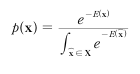

In [23]:
# 문제점을 개선 : 2019년도 논문 Implicit Generatioin and Modeling with Energy-Based Models 아이디어를 채용

In [24]:
# 데이터 셋  MNIST 데이터셋
from tensorflow.keras import datasets
(x_train,y_train), (x_test,y_test) = datasets.mnist.load_data()


In [25]:
x_train.shape

(60000, 28, 28)

In [26]:
# 효율적이 학습을 위해서 픽셀값을 [-1,1] 조정하고 32X32픽셀로 패딩 추가
# 데이터 정규화 : 보통 이미지데이터는 0~1사이의 값으로 표현, -1 ~ 1로 조정을 하면 중앙 0 주변에 데이터가 분포해서
# 신경망이 더 빠르게 학습하고 안정적으로...
# 32 32 패딩추가 : 원래는 28 28 -> 32 32 입력크기를 조정(패딩을 추가) --> 모델이 미묘한 특징을 감지하는데 도움

In [27]:
# 전처리
import numpy as np
def preprocess(imgs):
  imgs = (imgs.astype('float32') - 127.5) / 127.5
  imgs = np.pad(imgs, ( (0,0), (2,2),(2,2)), constant_values = -1.0)
  imgs = np.expand_dims(imgs,-1)
  return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)
x_train.shape

(60000, 32, 32, 1)

In [28]:
import tensorflow as tf
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(128)
x_test = tf.data.Dataset.from_tensor_slices(x_test).batch(128)

In [29]:
next(iter(x_train)).shape, next(iter(x_test)).shape

(TensorShape([128, 32, 32, 1]), TensorShape([128, 32, 32, 1]))

In [30]:
# 에너지함수 : 파라미터가 쎄타이고 입력이미지 x를 하나의 스칼라값으로 변환하는 신경망
# 이걸 위해서 활성화함수로 swixh(스위시)사용

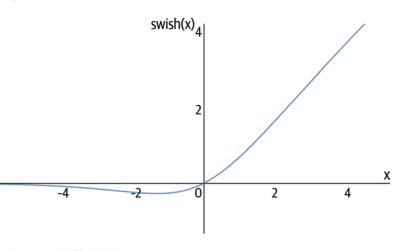

In [31]:
# 스위시 함수는 Relu대안 2017년도 구글에서 소개

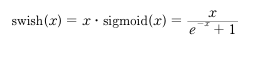

In [32]:
from tensorflow.keras import(
    layers,models,optimizers,activations,metrics,callbacks
)

In [33]:
ebm_input = layers.Input(shape=(32,32,1))
x = layers.Conv2D(16,kernel_size = 5,strides=2,padding='same',activation = activations.swish)(ebm_input)
x = layers.Conv2D(32,kernel_size = 3,strides=2,padding='same',activation = activations.swish)(x)
x = layers.Conv2D(64,kernel_size = 3,strides=2,padding='same',activation = activations.swish)(x)
x = layers.Conv2D(64,kernel_size = 3,strides=2,padding='same',activation = activations.swish)(x)
x = layers.Flatten()(x)
x = layers.Dense(64,activation =activations.swish)(x)
ebm_output = layers.Dense(1)(x)
model = models.Model(ebm_input,ebm_output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 16)        416       
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 2, 2, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                1644

In [34]:
# 에너지 함수 : 입력에 대해서 하나의 점수만 출력, 에너지 점수가 낮은 새로운 샘플을 생성?
# 에너지 함수 기울기를 계산--> Langevin dynamics  랑주뱅 다이나믹기법을 이용해서 그레이디언트 계산
# 경사하강법과 차이가 있다
# 신경망의 가중치를 고정한상태에서 입력대비 출력에 대한 기울기(미분)를 계산 -> 음의방향으로 조금씩 업데이트

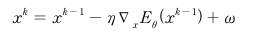

In [35]:
# Langevin dynamics를 사용해서 셈플을 생성하는 함수 - 무작위 노이즈와 그레이디언트를 활용
# 샘플공간에서 낮은 에너지를 작는 새로운 포인트를 샘플링 하는 방법
def generate_samples(model,inp_imgs, steps,step_size,noise ,return_img_per_step = False):
  img_per_step = []
  for _ in range(steps):
    inp_imgs += tf.random.normal(inp_imgs.shape,mean = 0 ,stddev = noise) # 무작위 노이즈를 추가
    inp_imgs = tf.clip_by_value(inp_imgs, -1.0,1.0)
    with tf.GradientTape() as tape: # 그레이디언트 계산
      tape.watch(inp_imgs)
      out_score = -model(inp_imgs) # 모델을 통과해서 점수 획득
    grads = tape.gradient(out_score, inp_imgs) # 입력에 대한 출력의 기울기
    grads = tf.clip_by_value(grads,-0.03,0.03)
    inp_imgs += step_size*grads # 작은양의 그레이디언트를 입력이미지에 더한
    inp_imgs = tf.clip_by_value(inp_imgs, -1.0,1.0)
    if return_img_per_step:
      img_per_step.append(inp_imgs)
  if return_img_per_step:
    return tf.stack(img_per_step,axis=0)
  else:
    return inp_imgs

In [36]:
# 2002년 제프리 힌튼 제안  contrastive divergence 기법
# 가짜 샘플을 계산하려면 정확히 샘플링을 해야 하는데. 분모를 계산하기가 어렵기  때무에 불가능
# 랑주뱅 다이나믹 기법을 이용해서 낮은 에너지 점수를 가진 샘플링을생성
# 이전반복의 샘플을 버퍼에 저장, 다음 배치의 시작점으로 잡음대신에 사용
import random
class Buffer:
  def __init__(self,model):
    self.model = model
    self.examples = [
        tf.random.uniform(shape = (1,32,32,1))*2-1 for _ in range(128)
    ] # 랜덤한 잡음
  def sample_new_examples(self,steps,step_size,noise):
    n_new = np.random.binomial(128,0.05) # 매번 평균적으로 샘플의 5%가 생성
    rand_imgs = (tf.random.uniform( (n_new,32,32,1))*2-1   )
    # 나머지는 기존 버퍼로부터 랜덤하게 추출
    old_imgs = tf.concat( random.choices(self.examples, k=128-n_new),axis=0  )
    inp_imgs = tf.concat([rand_imgs,old_imgs],axis=0)
    inp_imgs = generate_samples(
        self.model,inp_imgs, steps = steps, step_size=step_size, noise=noise
    )  # 샘플을 합치고 랑주뱅 샘플링을 한다
    self.examples = tf.split(inp_imgs,128,axis=0) + self.examples  # 버퍼에추가하고 최대 심플 개수를  제한
    self.examples = self.examples[:8192]  # 메모리문제때문에....
    return inp_imgs

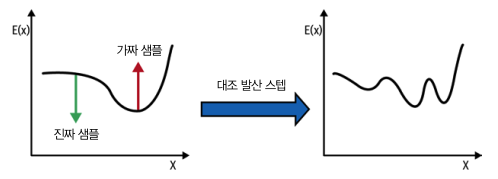

In [37]:
# 훈련모델
class EBM(models.Model):
    def __init__(self):
        super(EBM, self).__init__()
        self.model = model
        self.buffer = Buffer(self.model)
        self.alpha = 0.1
        self.loss_metric = metrics.Mean(name="loss")
        self.reg_loss_metric = metrics.Mean(name="reg")
        self.cdiv_loss_metric = metrics.Mean(name="cdiv")
        self.real_out_metric = metrics.Mean(name="real")
        self.fake_out_metric = metrics.Mean(name="fake")

    @property
    def metrics(self):
        return [
            self.loss_metric,
            self.reg_loss_metric,
            self.cdiv_loss_metric,
            self.real_out_metric,
            self.fake_out_metric,
        ]

    def train_step(self, real_imgs):
        real_imgs += tf.random.normal(
            shape=tf.shape(real_imgs), mean=0, stddev=0.005
        )  # 진짜 이미지에 작은 양의 랜덤한 잡음을 추가-> 과대적합방지

        real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0)
        fake_imgs = self.buffer.sample_new_examples(
            steps=60, step_size=10, noise=0.005
        ) # 가짜이미지를 버퍼에서 샘플링
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        with tf.GradientTape() as training_tape:
            real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)  #진짜/가짜 이미지를 모델에 통과 점수획득
            cdiv_loss = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
                real_out, axis=0
            ) #대조발산 손실( 진짜 샘플점수와 가짜  샘플점수의 차이)
            reg_loss = self.alpha * tf.reduce_mean(
                real_out**2 + fake_out**2, axis=0
            ) # 점수가 너무 커지지 않도록 규제를 적용
            loss = cdiv_loss + reg_loss
        grads = training_tape.gradient(loss, self.model.trainable_variables)  #역전파통해 그레디언트 계산
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables)
        )
        self.loss_metric.update_state(loss)
        self.reg_loss_metric.update_state(reg_loss)
        self.cdiv_loss_metric.update_state(cdiv_loss)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, real_imgs):   # 검증용
        batch_size = real_imgs.shape[0]
        fake_imgs = (
            tf.random.uniform((batch_size, 32, 32, 1))
            * 2
            - 1
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
        cdiv = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
            real_out, axis=0
        )
        self.cdiv_loss_metric.update_state(cdiv)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics[2:]}


In [38]:
# EBM 신경망 훈련
ebm = EBM()
ebm.compile(
    optimizer = 'adam',run_eagerly = True   # 텐서플로우의 eager execution모드 활성
)

In [39]:
# 훈련과정을 모니터링하고 시각화
tensorboard_callback = callbacks.TensorBoard(log_dir='./logs')

In [40]:
from myutils import display, sample_batch
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        start_imgs = (
            np.random.uniform(
                size=(self.num_img, 32, 32, 1)
            )
            * 2
            - 1
        )
        generated_images = generate_samples(
            ebm.model,
            start_imgs,
            steps=1000,
            step_size=10,
            noise=0.005,
            return_img_per_step=False,
        )
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )

        example_images = tf.concat(
            random.choices(ebm.buffer.examples, k=10), axis=0
        )
        example_images = example_images.numpy()
        display(
            example_images, save_to="./output/example_img_%03d.png" % (epoch)
        )


image_generator_callback = ImageGenerator(num_img=10)

In [ ]:
ebm.fit(
    x_train,
    shuffle=True,
    epochs=3,
    validation_data = x_test,
    callbacks=[
        tensorboard_callback,image_generator_callback
    ]
)

Epoch 1/3
181/469 [==========>...................] - ETA: 7:51 - loss: -4.9979 - reg: 4.9899 - cdiv: -9.9878 - real: 4.9993 - fake: -4.9885

In [ ]:
start_imgs = (
    np.random.uniform(size=(10, 32,32,1))*2-1
)
display(start_imgs)

In [ ]:
gen_img = generate_samples(
    ebm.model,
    start_imgs,
    steps = 1000,
    step_size = 10,
    noise = 0.0005,
    return_img_per_step = True,
)
display(gen_img[-1].numpy())

In [ ]:
!pip install jupyter-tensorboard

In [47]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [51]:
%tensorboard --logdir './logs'

<IPython.core.display.Javascript object>

In [50]:
!kill 5188